Dataset

In [20]:
import sys
sys.path.append("..")

from src import dataset
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary



In [3]:

df = dataset.process_metadata("clear_2018/clear_2018.csv")
df

,Unnamed: 0,user,ROI,sen2,cloud_per,cloud_coverage,sensing_time,year,path
0,55,ANDREA,point_0502,20180316T103021_20180316T103018_T33VWJ,0.0,cloud-free,20180316T103021,2018,clear_2018\point_0502\20180316T103021_20180316...
1,70,ANDREA,point_0511,20180404T092031_20180404T092028_T36VVP,0.0,cloud-free,20180404T092031,2018,clear_2018\point_0511\20180404T092031_20180404...
2,190,ANDREA,point_0564,20180204T112249_20180204T112254_T29TNE,0.0,cloud-free,20180204T112249,2018,clear_2018\point_0564\20180204T112249_20180204...
3,205,ANDREA,point_0573,20181220T051219_20181220T051613_T44RQS,0.0,cloud-free,20181220T051219,2018,clear_2018\point_0573\20181220T051219_20181220...
4,415,ANDREA,point_0839,20181215T074319_20181215T074319_T38RPV,0.0,cloud-free,20181215T074319,2018,clear_2018\point_0839\20181215T074319_20181215...
...,...,...,...,...,...,...,...,...,...
203,9940,WENDY,point_8417,20181222T082341_20181222T083220_T35PQP,0.0,cloud-free,20181222T082341,2018,clear_2018\point_8417\20181222T082341_20181222...
204,9960,CESAR,point_8945,20180705T100031_20180705T100508_T33TWL,0.0,cloud-free,20180705T100031,2018,clear_2018\point_8945\20180705T100031_20180705...
205,9980,WENDY,point_9976,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,20181217T055231,2018,clear_2018\point_9976\20181217T055231_20181217...
206,9985,WENDY,point_9980,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,20181217T055231,2018,clear_2018\point_9980\20181217T055231_20181217...


In [4]:
ds = dataset.TiffDataset(df)
len(ds)

208

In [5]:
idx = np.random.randint(0,len(ds))
print(idx)
item = ds[idx]
item["sl1c"].shape,item["sl2a"].shape

52


(torch.Size([13, 509, 509]), torch.Size([12, 509, 509]))

Text(0.5, 1.0, 'L2A')

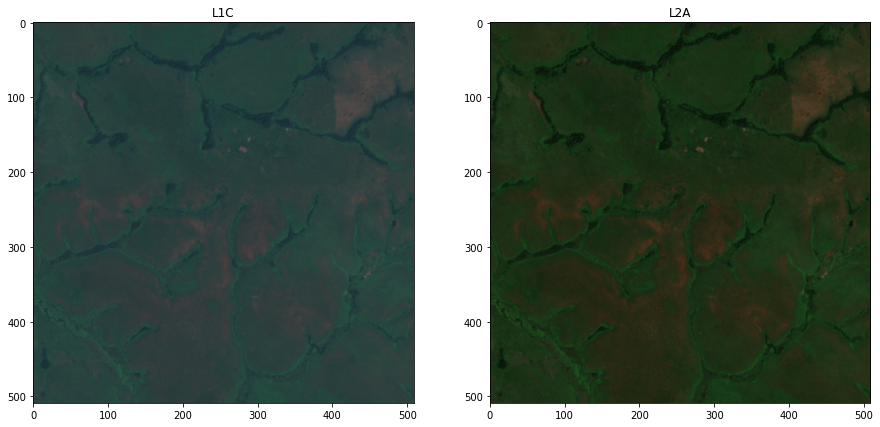

In [6]:
BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

In [7]:
ds_256=[]

for idx in range(len(ds)):
    ds_256.append({'sl1c':ds[idx]['sl1c'][:,:256,:256], 'sl2a':ds[idx]['sl2a'][:,:256,:256]})
    ds_256.append({'sl1c':ds[idx]['sl1c'][:,:256,253:], 'sl2a':ds[idx]['sl2a'][:,:256,253:]})
    ds_256.append({'sl1c':ds[idx]['sl1c'][:,253:,:256], 'sl2a':ds[idx]['sl2a'][:,253:,:256]})
    ds_256.append({'sl1c':ds[idx]['sl1c'][:,253:,253:], 'sl2a':ds[idx]['sl2a'][:,253:,253:]})

In [8]:
len(ds_256)

832

In [10]:
torch.save(ds_256, 'data/ds_256.pt')

Data Preparation

In [11]:
sample_permutation = np.random.permutation(len(ds_256))

random_train_samples = sample_permutation[:int(0.6*len(ds_256))]
random_val_samples = sample_permutation[int(0.6*len(ds_256)):int(0.8*len(ds_256))]
random_test_samples = sample_permutation[int(0.8*len(ds_256)):]

In [12]:
print(len(random_train_samples))
print(len(random_val_samples))
print(len(random_test_samples))

499
166
167


In [13]:
train_ds = []
val_ds = []
test_ds = []

for idx in random_train_samples:
    train_ds.append(ds_256[idx])
    
for idx in random_val_samples:
    val_ds.append(ds_256[idx])

for idx in random_test_samples:
    test_ds.append(ds_256[idx])

In [14]:
#Convert data list to torch tensors, separating input (sl1c) and target (sl2a) images.


train_input=[]
train_target=[]

for idx in range(len(train_ds)):
    train_input.append(train_ds[idx]['sl1c'])
    train_target.append(train_ds[idx]['sl2a'])

train_input = torch.stack(train_input)
train_target = torch.stack(train_target)

val_input=[]
val_target=[]

for idx in range(len(val_ds)):
    val_input.append(val_ds[idx]['sl1c'])
    val_target.append(val_ds[idx]['sl2a'])

val_input = torch.stack(val_input)
val_target = torch.stack(val_target)

test_input=[]
test_target=[]

for idx in range(len(test_ds)):
    test_input.append(test_ds[idx]['sl1c'])
    test_target.append(test_ds[idx]['sl2a'])

test_input = torch.stack(test_input)
test_target = torch.stack(test_target)

In [15]:
print('Train: ', train_input.shape, train_target.shape)
print('Validation: ', val_input.shape, val_target.shape)
print('Test: ', test_input.shape, test_target.shape)

Train:  torch.Size([499, 13, 256, 256]) torch.Size([499, 12, 256, 256])
Validation:  torch.Size([166, 13, 256, 256]) torch.Size([166, 12, 256, 256])
Test:  torch.Size([167, 13, 256, 256]) torch.Size([167, 12, 256, 256])


Models

U-NET

In [16]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class UNET(nn.Module):
    def __init__(self, in_channels=13, out_channels=12, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="relu", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="relu", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="relu", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [18]:
model = UNET()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          13,376
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
              ReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
              ReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
             ReLU-13          [-1, 512, 16, 16]               0
            Block-14          [-1, 512,

In [19]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = UNET()
preds = model(x)
print(preds.shape)

torch.Size([1, 12, 256, 256])


FCNN

In [21]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        # Learnable layers
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=12, kernel_size=5, padding=2)


    def forward(self, x):
        # x.size() = (N, 13, W, W) 
        x = F.relu(self.conv1(x)) 
        # x.size() = (N, 16, W, W) 
        x = F.relu(self.conv2(x))
        # x.size() = (N, 32, W, W) 
        x = F.relu(self.conv3(x))
        # x.size() = (N, 16, W, W)
        x = self.conv4(x)
        # x.size() = (N, 12, W, W)
        return x

In [22]:
model = FCNN()
summary(model, (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,888
            Conv2d-2         [-1, 32, 256, 256]           4,640
            Conv2d-3         [-1, 16, 256, 256]           4,624
            Conv2d-4         [-1, 12, 256, 256]           4,812
Total params: 15,964
Trainable params: 15,964
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.25
Forward/backward pass size (MB): 38.00
Params size (MB): 0.06
Estimated Total Size (MB): 41.31
----------------------------------------------------------------


In [23]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = FCNN()
preds = model(x)
print(preds.shape)

torch.Size([1, 12, 256, 256])


Train

In [27]:
# initialize our model
model = FCNN()

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), lr=0.001)

# calculate steps per epoch for training and test set
trainSteps = len(train_input)
valSteps = len(val_input)

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 15

In [28]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for idx in range(len(train_input)):
		# send the input to the device
		x = train_input[idx].reshape(1,train_input[idx].shape[0], train_input[idx].shape[1], train_input[idx].shape[2])
		y = train_target[idx].reshape(1,train_target[idx].shape[0], train_target[idx].shape[1], train_target[idx].shape[2])

		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFunc(pred, y)

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for idx in range(len(val_input)):
			# send the input to the device
			x = val_input[idx].reshape(1,val_input[idx].shape[0], val_input[idx].shape[1], val_input[idx].shape[2])
			y = val_target[idx].reshape(1,val_target[idx].shape[0], val_target[idx].shape[1], val_target[idx].shape[2])

			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFunc(pred, y)

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print("Train loss: {:.6f}, Val loss: {:.4f}".format(
		avgTrainLoss, avgValLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

  0%|          | 0/15 [00:00<?, ?it/s]

[INFO] training the network...


  7%|▋         | 1/15 [01:29<20:46, 89.05s/it]

[INFO] EPOCH: 1/15
Train loss: 0.009578, Val loss: 0.0096


 13%|█▎        | 2/15 [03:04<19:40, 90.84s/it]

[INFO] EPOCH: 2/15
Train loss: 0.005713, Val loss: 0.0041


 20%|██        | 3/15 [04:39<18:27, 92.30s/it]

[INFO] EPOCH: 3/15
Train loss: 0.005677, Val loss: 0.0104


 27%|██▋       | 4/15 [06:15<17:07, 93.45s/it]

[INFO] EPOCH: 4/15
Train loss: 0.004689, Val loss: 0.0025


 33%|███▎      | 5/15 [07:50<15:39, 93.93s/it]

[INFO] EPOCH: 5/15
Train loss: 0.002720, Val loss: 0.0023


 40%|████      | 6/15 [09:24<14:04, 93.87s/it]

[INFO] EPOCH: 6/15
Train loss: 0.003543, Val loss: 0.0032


 47%|████▋     | 7/15 [10:26<11:15, 84.39s/it]

[INFO] EPOCH: 7/15
Train loss: 0.003404, Val loss: 0.0037


 53%|█████▎    | 8/15 [11:25<08:56, 76.69s/it]

[INFO] EPOCH: 8/15
Train loss: 0.002372, Val loss: 0.0023


 60%|██████    | 9/15 [12:25<07:10, 71.77s/it]

[INFO] EPOCH: 9/15
Train loss: 0.002392, Val loss: 0.0022


 67%|██████▋   | 10/15 [13:30<05:48, 69.73s/it]

[INFO] EPOCH: 10/15
Train loss: 0.002728, Val loss: 0.0024


 73%|███████▎  | 11/15 [14:32<04:29, 67.29s/it]

[INFO] EPOCH: 11/15
Train loss: 0.003593, Val loss: 0.0038


 80%|████████  | 12/15 [15:32<03:15, 65.13s/it]

[INFO] EPOCH: 12/15
Train loss: 0.002729, Val loss: 0.0021


 87%|████████▋ | 13/15 [16:37<02:10, 65.12s/it]

[INFO] EPOCH: 13/15
Train loss: 0.003568, Val loss: 0.0024


 93%|█████████▎| 14/15 [17:39<01:03, 63.99s/it]

[INFO] EPOCH: 14/15
Train loss: 0.002891, Val loss: 0.0022


100%|██████████| 15/15 [18:45<00:00, 75.02s/it]

[INFO] EPOCH: 15/15
Train loss: 0.002728, Val loss: 0.0022
[INFO] total time taken to train the model: 1125.34s


Plot predictions

In [29]:
preds = model(test_input)

Text(0.5, 1.0, 'pred')

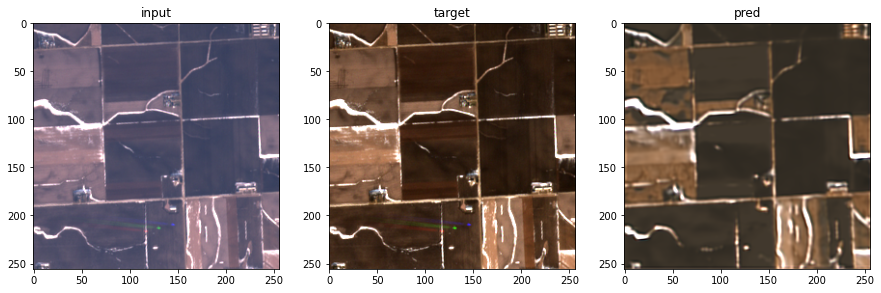

In [50]:
idx = np.random.randint(0,len(test_input))

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(test_input[idx])[bands_rgb_l2a,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(test_target[idx])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[idx][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("input")
ax[1].imshow(rgb_l2a)
ax[1].set_title("target")
ax[2].imshow(predic)
ax[2].set_title("pred")

In [51]:
torch.save(model.state_dict(), 'saved_models/model_fcnn_e15.pth')

Check predictions for original images

203
torch.Size([1, 12, 509, 509])


Text(0.5, 1.0, 'pred')

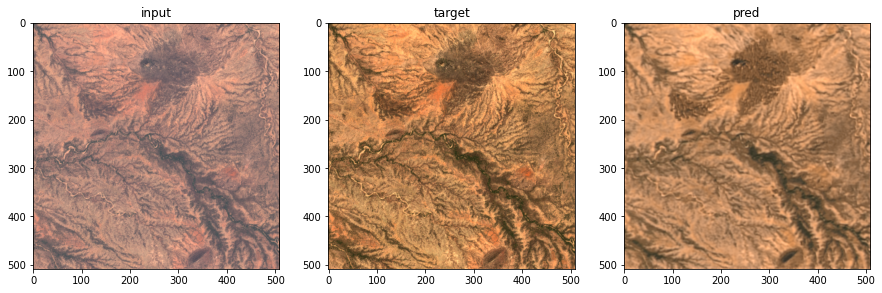

In [69]:
idx = np.random.randint(0,len(ds))
print(idx)
item = ds[idx]

x = item['sl1c']
ii = model(x.reshape(1, x.shape[0], x.shape[1], x.shape[2]))
print(ii.shape)

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item['sl1c'])[bands_rgb_l2a,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item['sl2a'])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = ii.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("input")
ax[1].imshow(rgb_l2a)
ax[1].set_title("target")
ax[2].imshow(predic)
ax[2].set_title("pred")